## Poisson VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Poisson base distribution with Log Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top}
$$

We run each scenario 5 times and compare the fit with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

┌ Info: Precompiling GLMCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1342


In [3]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
βtrue = ones(p)
Σtrue = [0.5]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; Σtrue] #hold true parameters

#simulation parameters
samplesizes = [1000; 10000; 100000]
ns = [2; 5; 10; 20; 50]
nsims = 50

50

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
ΣMseresult = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


750-element Vector{Float64}:
   0.082370935
   0.081128432
   0.107628133
   0.087959758
   0.200774436
   0.089785822
   0.185327221
   0.098323445
   0.08737965
   0.087250977
   0.180576707
   0.089371441
   0.091996137
   ⋮
  99.65784105
  83.473382459
  81.936798415
 202.728864864
  89.416757878
 106.606106127
 106.660198969
  95.622583015
  79.78846759
 107.316030041
 103.131898392
 137.846108112

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

750-element Vector{Float64}:
   0.449594117
   0.171725668
   0.17357376
   0.149966129
   0.212376678
   0.166136488
   0.173839744
   0.182783456
   0.220149231
   0.188772079
   0.200102211
 NaN
   0.197609689
   ⋮
 447.315192542
 380.034322253
 489.945220562
 471.927352146
 440.862357925
 431.295404413
 424.555236303
 440.31637005
 427.311417436
 430.636878445
 437.32567861
 426.284961946

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,1000,2,0.109342,0.00589054,2000,0.103452,0.121123,5.46712e-5
2,1000,5,0.21105,0.0243124,5000,0.186738,0.259675,4.221e-5
3,1000,10,0.27596,0.0151166,10000,0.260843,0.306193,2.7596e-5
4,1000,20,0.407751,0.0123504,20000,0.395401,0.432452,2.03876e-5
5,1000,50,0.926534,0.0256058,50000,0.900928,0.977746,1.85307e-5
6,10000,2,0.944073,0.0150353,20000,0.929038,0.974144,4.72037e-5
7,10000,5,1.71025,0.0514506,50000,1.6588,1.81316,3.42051e-5
8,10000,10,3.30731,0.23235,100000,3.07496,3.77201,3.30731e-5
9,10000,20,5.20636,0.218033,200000,4.98832,5.64242,2.60318e-5


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,1000,2,NaN,NaN,2000,NaN,NaN,NaN
2,1000,5,0.453997,0.00904969,5000,0.444947,0.463046,9.07993e-5
3,1000,10,0.817238,0.0081156,10000,0.809123,0.825354,8.17238e-5
4,1000,20,1.61002,0.0194045,20000,1.59062,1.62942,8.0501e-5
5,1000,50,4.19422,0.0505105,50000,4.14371,4.24473,8.38844e-5
6,10000,2,NaN,NaN,20000,NaN,NaN,NaN
7,10000,5,NaN,NaN,50000,NaN,NaN,NaN
8,10000,10,7.17066,0.0748832,100000,7.09577,7.24554,7.17066e-5
9,10000,20,14.8765,0.166497,200000,14.71,15.043,7.43827e-5


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: Removed 6 row(s) containing missing values (geom_path).
│ Warning: Removed 6 rows containing missing values (geom_point).
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


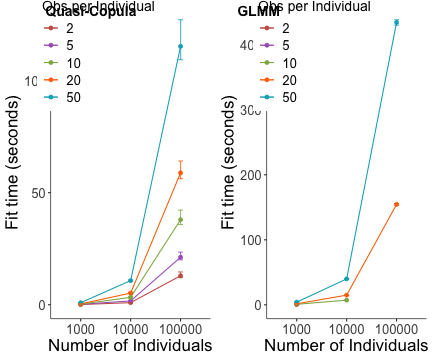

RObject{VecSxp}


In [8]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '20', '50'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('1000', '10000', '100000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '20', '50'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('1000', '10000', '100000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [15]:
R"""
ggsave('fittime_nsamples_poisson_vs_glmm.png', fittime_nsamples, width = 15, height = 17, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nsamples_poisson_vs_glmm.png"


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: Removed 1 row(s) containing missing values (geom_path).
│ Warning: Removed 6 rows containing missing values (geom_point).
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


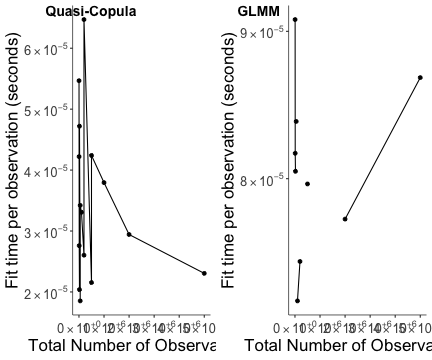

RObject{VecSxp}


In [9]:
using RCall
@rput timedf1
@rput timedf2

R"""
library(scales)
library(ggplot2)
timedf1$obssize <- factor(timedf1$obssize, levels = c('2', '5', '10', '20', '50'))
timedf1$samplesize <- factor(timedf1$samplesize, levels = c('1000', '10000', '100000'))

fancy_scientific <- function(l) {
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     # return this as an expression
     parse(text=l)
}

fittimeperobs1 = ggplot(timedf1, aes(x=nobs, y=perobsratio)) + 
  geom_line() +
  geom_point()+
#  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=11),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
#scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
scale_y_continuous(breaks = c(10^-5, 2 * 10^-5, 3 * 10^-5, 4 * 10^-5, 5 * 10^-5, 6 * 10^-5, 7  * 10^-5, 8  * 10^-5 , 9  * 10^-5, 10^-4), labels= fancy_scientific)

# glmm fit times
timedf2$obssize <- factor(timedf2$obssize, levels = c('2', '5', '10', '20', '50'))
timedf2$samplesize <- factor(timedf2$samplesize, levels = c('1000', '10000', '100000'))

fancy_scientific <- function(l) {
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     # return this as an expression
     parse(text=l)
}

fittimeperobs2 = ggplot(timedf2, aes(x=nobs, y=perobsratio)) + 
  geom_line() +
  geom_point()+
#  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=11),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
#scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
scale_y_continuous(breaks = c(10^-5, 2 * 10^-5, 3 * 10^-5, 4 * 10^-5, 5 * 10^-5, 6 * 10^-5, 7  * 10^-5, 8  * 10^-5 , 9  * 10^-5, 10^-4), labels= fancy_scientific)

fittime_perobs = plot_grid(fittimeperobs1, fittimeperobs2, labels = c("Quasi-Copula", "GLMM"))

"""

In [11]:
R"""
ggsave('fittime_perobs_poisson_vs_glmm.png', fittime_perobs, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_perobs_poisson_vs_glmm.png"


In [10]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βΣcoverage = readdlm("beta_sigma_coverage_multivariate_poisson_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βΣcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,Σ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 1000 ni: 2,"(0.48, 0.0713714)","(0.72, 0.0641427)","(0.86, 0.0495696)","(0.98, 0.02)"
2,N: 1000 ni: 5,"(0.62, 0.0693409)","(0.68, 0.0666395)","(0.82, 0.0548839)","(1.0, 0.0)"
3,N: 1000 ni: 10,"(0.64, 0.0685714)","(0.76, 0.0610119)","(0.74, 0.062662)","(0.92, 0.0387562)"
4,N: 1000 ni: 20,"(0.74, 0.062662)","(0.8, 0.0571429)","(0.84, 0.0523723)","(0.86, 0.0495696)"
5,N: 1000 ni: 50,"(0.6, 0.0699854)","(0.66, 0.0676727)","(0.86, 0.0495696)","(0.76, 0.0610119)"
6,N: 10000 ni: 2,"(0.66, 0.0676727)","(0.78, 0.059178)","(0.82, 0.0548839)","(0.92, 0.0387562)"
7,N: 10000 ni: 5,"(0.66, 0.0676727)","(0.74, 0.062662)","(0.86, 0.0495696)","(0.96, 0.0279942)"
8,N: 10000 ni: 10,"(0.72, 0.0641427)","(0.84, 0.0523723)","(0.72, 0.0641427)","(0.88, 0.0464231)"
9,N: 10000 ni: 20,"(0.6, 0.0699854)","(0.72, 0.0641427)","(0.78, 0.059178)","(0.94, 0.0339267)"


In [11]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresultpoisson = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

βMseresultpoisson_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresultpoisson, Σmse = ΣMseresultpoisson, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresultpoisson_GLMM, Σmse = ΣMseresultpoisson_GLMM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :Sigmamse]; msedf2[!, :betamse]; msedf2[!, :Sigmamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Poisson Quasi-Copula"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Poisson GLMM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,7.03947e-5,2,1000,beta,Poisson Quasi-Copula
2,0.000150224,2,1000,beta,Poisson Quasi-Copula
3,0.00020374,2,1000,beta,Poisson Quasi-Copula
4,0.000623339,2,1000,beta,Poisson Quasi-Copula
5,5.10073e-6,2,1000,beta,Poisson Quasi-Copula
6,2.78376e-5,2,1000,beta,Poisson Quasi-Copula
7,3.94621e-5,2,1000,beta,Poisson Quasi-Copula
8,0.000257277,2,1000,beta,Poisson Quasi-Copula
9,0.000750903,2,1000,beta,Poisson Quasi-Copula


┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


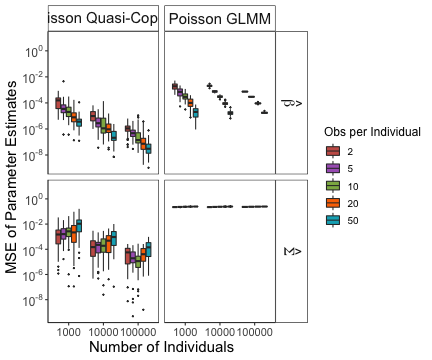

RObject{VecSxp}


In [12]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^1]
msedfR[parameters == "Sigma",y_min := 10^-5]
msedfR[parameters == "Sigma",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '20', '50'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('1000', '10000', '100000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'Sigma'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(Sigma))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Poisson Quasi-Copula', 'Poisson GLMM'),
    labels = c(expression(paste("Poisson Quasi-Copula")), expression(paste("Poisson GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [13]:
R"""
ggsave('updated_msefacetplot_poisson.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_poisson.png"
